# Step wedge

## Load some modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

import importlib
import sys

sys.path.append('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil\\notebooks')

import amglib.imageutils as amg
import amglib.readers as rd
import amglib.bb as bb

In [2]:
import os

os.chdir('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil')

In [3]:
dc = rd.readImages('data/02_rawdata/01_Stepwedges/dc_{0:05d}.fits',first=1,last=11).astype(float).mean(axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
dc.shape

(1201, 1201)

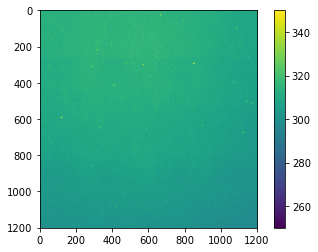

In [5]:
plt.imshow(dc,vmin=250,vmax=350)
plt.colorbar()

##### Average dark current bias

In [6]:
np.mean(dc)

309.07270283115685

### Open beam 

In [7]:
ob = rd.readImages('data/02_rawdata/01_Stepwedges/ob_{0:05d}.fits',first=1,last=11).astype(float).mean(axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

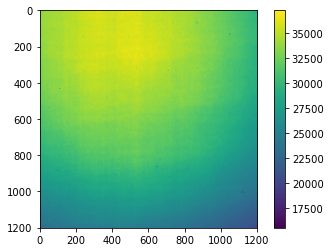

In [8]:
plt.imshow(ob)
plt.colorbar()

In [9]:
water = rd.readImages('data/02_rawdata/01_Stepwedges/water_{0:05d}.fits',first=1,last=6).astype(float).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

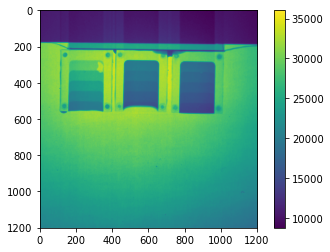

In [10]:
plt.imshow(water)
plt.colorbar()

### Normalize (Beer Lambert)

$$p=-log(\frac{I-I_{dc}}{I_{ob}-I_{dc}})$$

In [11]:
ob = ob -dc
ob[ob<1]=1
ob= ob[::-1]

water = water -dc
water[water<1]=1
water = water[::-1]

Measure the intensity 'dose' in the open beam and water image. Use this as scaling in the normalization.

In [12]:
d0=ob[10:50,10:50].mean()
d=water[10:50,10:50].mean()

In [13]:
p = -np.log(d0/d*(water)/(ob))

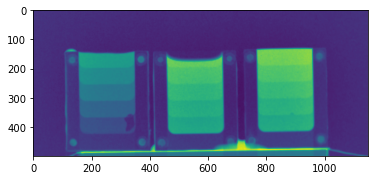

In [14]:
plt.imshow(p[500:1000,0:1150])

In [15]:
p=p[500:1000,0:1150]

## Look at the profile plots

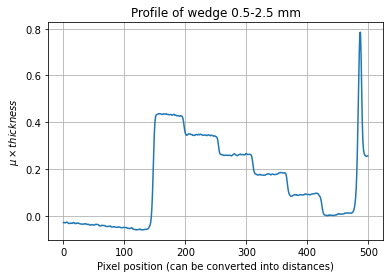

In [16]:
plt.plot(p[:,200:250].mean(axis=1))
plt.title('Profile of wedge 0.5-2.5 mm')
plt.xlabel('Pixel position (can be converted into distances)')
plt.ylabel(r'$\mu\times thickness$')
plt.grid()

### Task
To measure the attenuation coefficien from the images. Compare when container images are used as OB images instead of the one without anything.

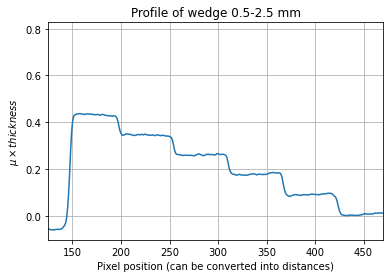

In [17]:
attenuation_coeffs = p[:, 200:250].mean(axis=1)
plt.plot(attenuation_coeffs)
plt.title('Profile of wedge 0.5-2.5 mm')
plt.xlabel('Pixel position (can be converted into distances)')
plt.xlim(125, 470)
plt.ylabel(r'$\mu\times thickness$')
plt.grid()

## Own analysis

###  Looking at all the stepwedges

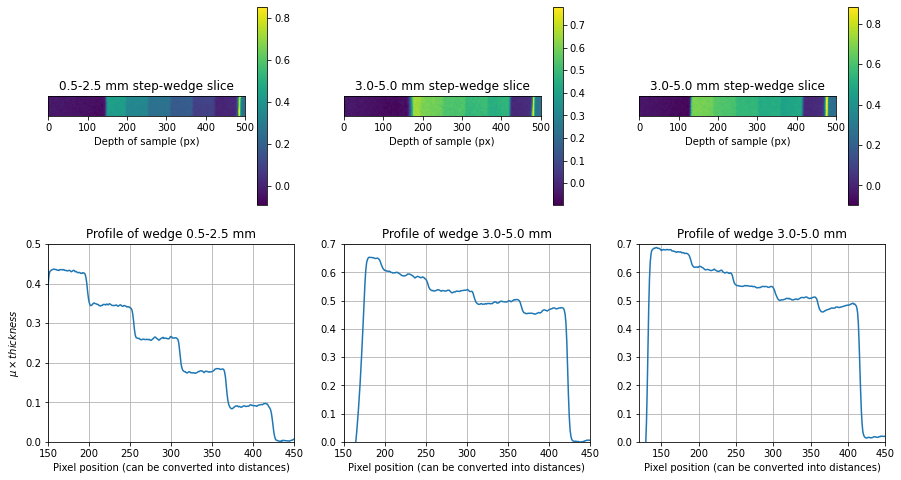

In [319]:
fig, ax = plt.subplots(2, 3)
# fig.set_size_inches(18, 10)
fig.set_size_inches(15, 8)
# fig.set_dpi(800)
ax = ax.ravel()

step_wedge_1 = p[:, 200:250]
step_wedge_2 = p[:, 500:550]
step_wedge_3 = p[:, 800:850]


ax[0].imshow(np.transpose(step_wedge_1))
ax[0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False
) # labels along the bottom edge are off
ax[0].set_title("0.5-2.5 mm step-wedge slice")
ax[0].set_xlabel("Depth of sample (px)")

ax[1].imshow(np.transpose(step_wedge_2), interpolation = 'none')
ax[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
ax[1].set_title("3.0-5.0 mm step-wedge slice")
ax[1].set_xlabel("Depth of sample (px)")

ax[2].imshow(np.transpose(step_wedge_3), interpolation = 'none')
ax[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
ax[2].set_title("3.0-5.0 mm step-wedge slice")
ax[2].set_xlabel("Depth of sample (px)")

ax[3].plot(step_wedge_1.mean(axis=1))
ax[3].set_title('Profile of wedge 0.5-2.5 mm')
ax[3].set_xlabel('Pixel position (can be converted into distances)')
ax[3].set_xlim(150, 450)
ax[3].set_ylim(0, 0.5)
ax[3].set_ylabel(r'$\mu\times thickness$')
ax[3].grid()

ax[4].plot(step_wedge_2.mean(axis=1))
ax[4].set_title('Profile of wedge 3.0-5.0 mm')
ax[4].set_xlabel('Pixel position (can be converted into distances)')
ax[4].set_xlim(150, 450)
ax[4].set_ylim(0, 0.7)
ax[4].grid()

ax[5].plot(step_wedge_3.mean(axis=1))
ax[5].set_title('Profile of wedge 3.0-5.0 mm')
ax[5].set_xlabel('Pixel position (can be converted into distances)')
ax[5].set_xlim(120, 450)
ax[5].set_ylim(0,0.7)
ax[5].grid()


for (axis, wedge) in zip(ax, [step_wedge_1, step_wedge_2, step_wedge_3]):
    pcm = axis.pcolormesh(np.transpose(wedge))
    fig.colorbar(pcm, ax=axis, shrink=1)

#### Find places where distance between adjacent points

In [298]:
swa = np.array([i.mean(axis=1) for i in [step_wedge_1, step_wedge_2, step_wedge_3]])

In [299]:
length = len(swa[1]) - 1
deltas = np.array([[swa[j, i+1] - swa[j, i] for i in range(length)] for j in [0,1,2]])

In [300]:
deltas = abs(deltas)

###### Testing background noise removal 

In [301]:
means = np.array([np.mean(deltas[i]) for i in range(3)])
sample_noise_means = np.array([np.mean(deltas[i, 200:240]) for i in range(3)])

# get_five_biggest_values = [np.argpartition(deltas[i], -5)[-5:] for i in range(3)]
# five_biggest_means = np.array([deltas[i][get_five_biggest_values[i]] for iin range(3)]).mean(axis=1)
# big_mean_correction = five_biggest_means / len(deltas)

backgrounds = np.array([np.full(499, means[i]) for i in range(3)])
adv_backgr = np.array([np.full(499, means[i] - sample_noise_means[i]) for i in range(3)]) # didn't work -> overcompensated

In [322]:
# backgrounds
# adv_backgr
# np.linalg.norm(backgrounds - adv_backgr)

In [323]:
# print(get_five_biggest_values)
for i in range(3):
    print(3*"****", f"{i}", 3*"****") 
    print("Indices")
    print(get_five_biggest_values[i])
    print(5*"****")
    print("Values")
    print(deltas[i, get_five_biggest_values[i]])

************ 0 ************
Indices
[482 483 489 488 484]
********************
Values
[0.12626497 0.14262148 0.13344624 0.15643158 0.13663971]
************ 1 ************
Indices
[478 485 480 479 484]
********************
Values
[0.11319282 0.12184994 0.16595443 0.15929423 0.14370651]
************ 2 ************
Indices
[480 132 131 473 474]
********************
Values
[0.14038738 0.14039263 0.14558068 0.16092513 0.14846874]


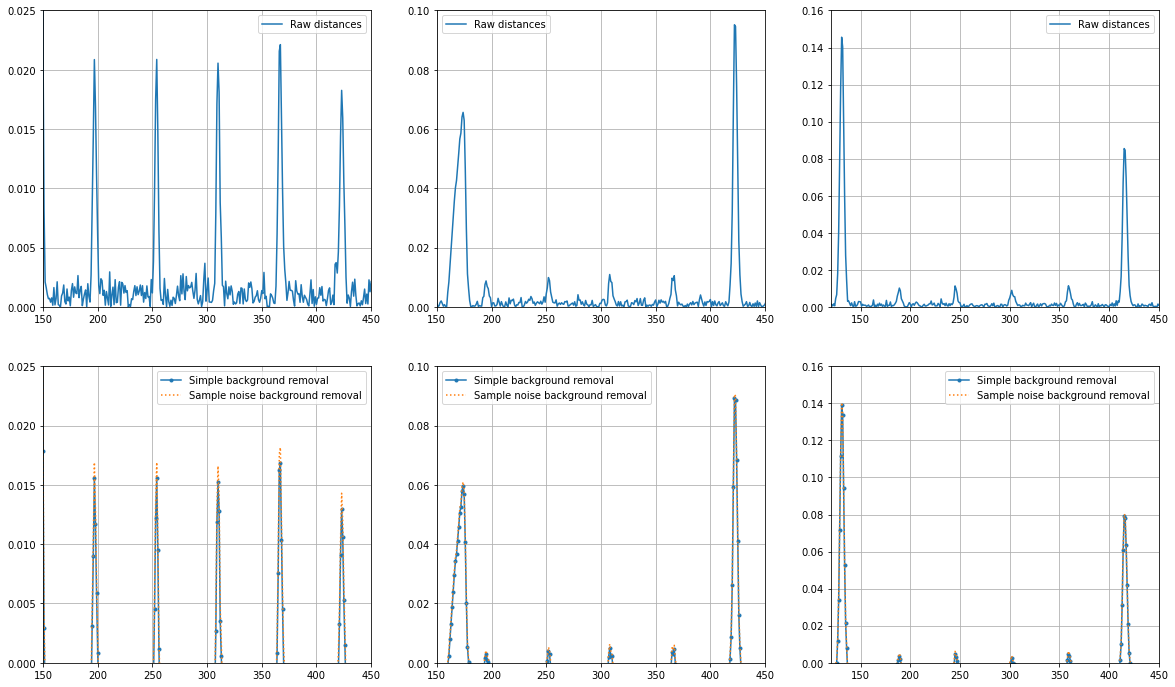

In [306]:
# Setup
fig, ax = plt.subplots(2, 3)
ax = ax.ravel()
fig.set_size_inches(20, 12)

# x vals
xvals = np.arange(0, 499, 1)

# plotting
ax[0].plot(xvals, deltas[0], label="Raw distances")
ax[0].set_xlim(150, 450)
ax[0].set_ylim(0, 0.025)
ax[0].grid()
ax[0].legend()

ax[1].plot(xvals, deltas[1], label="Raw distances")
ax[1].set_xlim(150, 450)
ax[1].set_ylim(0, 0.1)
ax[1].grid()
ax[1].legend()

ax[2].plot(xvals, deltas[2], label="Raw distances")
ax[2].set_xlim(120, 450)
ax[2].set_ylim(0, 0.16)
ax[2].grid()
ax[2].legend()

ax[3].plot(xvals, deltas[0] - backgrounds[0], ".-", label = "Simple background removal")
ax[3].plot(xvals, deltas[0] - adv_backgr[0], ":", label = "Sample noise background removal")
ax[3].set_xlim(150, 450)
ax[3].set_ylim(0, 0.025)
ax[3].grid()
ax[3].legend()

ax[4].plot(xvals, deltas[1] - backgrounds[1], ".-", label = "Simple background removal")
ax[4].plot(xvals, deltas[1] - adv_backgr[1], ":", label = "Sample noise background removal")
ax[4].set_xlim(150, 450)
ax[4].set_ylim(0, 0.1)
ax[4].grid()
ax[4].legend()

ax[5].plot(xvals, deltas[2] - backgrounds[2], ".-", label = "Simple background removal")
ax[5].plot(xvals, deltas[2] - adv_backgr[2], ":", label = "Sample noise background removal")
ax[5].set_xlim(120, 450)
ax[5].set_ylim(0, 0.16)
ax[5].grid()
ax[5].legend()

In [324]:
# get_five_biggest_values
# deltas[1, get_five_biggest_values]

In [325]:
peaks = np.array([deltas[i] - adv_backgr[i] for i in range(3)])

In [326]:
peaks.mean(axis=1)

array([0.00131305, 0.0013435 , 0.0013265 ])

In [330]:
big_points = [np.where( (peaks[i] > peaks[i].mean()) & (peaks[i] > 0)) for i in range(3)]

In [317]:
# peaks[1][big_points[1][0]]

In [318]:
for i in range(3):
    values = big_points[i][0]
    values = peaks[i][values]  
#     print(values)
#     print(len(values))
# peaks[1][big_points[1][0]]  

##### Plotting segments, differences and noise removed differences 

#### Finding the star / end points to the staircase structure

## Black body correction
Scattered neutrons introduce a bias in the values. This can be corrected using black body images.

In [23]:
np.convolve(step_wedge_3.mean(axis=1), backgrounds[2]).shape

(998,)

# Abandoned attempts 

In [331]:
# fig, ax = plt.subplots(3, 3)
# # fig.set_size_inches(18, 10)
# fig.set_size_inches(18, 15)
# # fig.set_dpi(800)
# ax = ax.ravel()

# xvals = np.arange(0, 499, 1)

# ax[0].plot(xvals, deltas[0])
# ax[0].set_title("||x[i] - x[i+1]|| without noise removal")
# ax[0].set_xlim(150, 450)
# ax[0].set_ylim(0, 0.025)
# ax[0].grid()

# ax[1].plot(xvals, deltas[1])
# ax[1].set_title("||x[i] - x[i+1]|| without noise removal")
# ax[1].set_xlim(150, 450)
# ax[1].set_ylim(0, 0.1)
# ax[1].grid()

# ax[2].plot(xvals, deltas[2])
# ax[2].set_title("||x[i] - x[i+1]|| without noise removal")
# ax[2].set_xlim(120, 450)
# ax[2].set_ylim(0, 0.16)
# ax[2].grid()


# ax[3].plot(deltas[0] - adv_backgr[0])
# ax[3].set_title("||x[i] - x[i+1]|| with noise removal")
# ax[3].set_xlim(150, 450)
# ax[3].set_ylim(0, 0.025)
# ax[3].grid()

# ax[4].plot(deltas[1] - adv_backgr[1])
# ax[4].set_title("||x[i] - x[i+1]|| with noise removal")
# ax[4].set_xlim(150, 450)
# ax[4].set_ylim(0, 0.1)
# ax[4].grid()


# ax[5].plot(deltas[2] - adv_backgr[2])
# ax[5].set_title("||x[i] - x[i+1]|| with noise removal")
# ax[5].set_xlim(120, 450)
# ax[5].set_ylim(0, 0.16)
# ax[5].grid()


# ax[6].plot(step_wedge_1.mean(axis=1))
# # ax[6].scatter(big_points[0][0], peaks[0][big_points[0][0]])
# ax[6].set_title('Profile of wedge 0.5-2.5 mm')
# ax[6].set_xlabel('Pixel position (can be converted into distances)')
# ax[6].set_xlim(150, 450)
# ax[6].set_ylim(0, 0.5)
# ax[6].set_ylabel(r'$\mu\times thickness$')
# ax[6].grid()

# ax[7].plot(step_wedge_2.mean(axis=1))
# ax[7].set_title('Profile of wedge 3.0-5.0 mm')
# # ax[7].scatter(big_points[1][0], step_wedge_1.mean(axis=1)[big_points[1][0]])
# ax[7].set_xlabel('Pixel position (can be converted into distances)')
# ax[7].set_xlim(150, 450)
# ax[7].set_ylim(0.4, 0.7)
# ax[7].grid()

# ax[8].plot(step_wedge_3.mean(axis=1), label = "Wedge")
# ax[8].set_title('Profile of wedge 3.0-5.0 mm')
# ax[8].set_xlabel('Pixel position (can be converted into distances)')
# ax[8].set_xlim(120, 450)
# ax[8].set_ylim(0.4,0.7)
# ax[8].grid()